In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/beijing.csv')

In [3]:
#Create a copy of dataset
data_imputed = data.copy()

In [4]:
# Define the imputation model
imputer = IterativeImputer(max_iter=10, random_state=0)
# Define the number of imputations
n_imputations = 5

In [5]:
for i in range(n_imputations):
    # Impute missing values using the MICE algorithm
    data_imputed.iloc[:, :] = imputer.fit_transform(data_imputed)

    # Store the imputed values in a new dataframe
    data_imputed_i = pd.DataFrame(imputer.transform(data),
                                   columns=data.columns)

    # Merge the imputed values with the original dataset
    data_imputed = data_imputed.combine_first(data_imputed_i)

##Model

In [6]:
# Create a new dataframe with only the 'pm2.5' column 
data1 = data_imputed.filter(['pm2.5'])
# Convert the dataframe to a numpy array
dataset = data1.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .6 ))

window_size = 60
training_data_len

26295

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# create scaler
scaler = StandardScaler()
# fit and transform in one step
scaled_data = scaler.fit_transform(dataset)

print ('scaled_data.shape',len(scaled_data))
scaled_data

scaled_data.shape 43824


array([[ 0.25122843],
       [ 0.35077507],
       [ 0.30783429],
       ...,
       [-0.97974765],
       [-1.00186566],
       [-0.95762965]])

In [8]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len)]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i<= window_size + 1:
        print('x_train',x_train)
        print('\ny_train',y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print ('x_train.shape:',x_train.shape)

x_train [array([ 0.25122843,  0.35077507,  0.30783429,  0.5365992 ,  0.46935314,
        0.40210708,  0.33845935,  0.35163367,  0.3610891 ,  0.2449246 ,
        0.23132364,  0.14708952,  0.13800429,  0.05377018,  0.0071105 ,
        0.07129275,  0.09053542,  0.23182744,  0.38165781,  0.36222547,
        0.45596849,  0.45462477,  0.47029686,  0.45943062,  0.33627355,
        0.54639459,  0.66804361,  0.91134164,  0.43580457,  0.11509352,
        0.07085751,  0.28097854,  0.23674254,  0.36945056,  0.45792257,
        0.59063059,  0.54639459,  0.72333861,  0.6569846 ,  0.6127486 ,
        0.66804361,  0.72333861,  0.78969262,  0.55745359,  0.6127486 ,
        0.72333861,  0.6348666 ,  0.30309655, -0.09502751, -0.39362056,
       -0.37150256, -0.48209258, -0.37150256, -0.17244053, -0.08396851,
       -0.13926352, -0.18349953, -0.13926352, -0.22773554, -0.0065555 ])]

y_train [0.09297551517702111]

x_train [array([ 0.25122843,  0.35077507,  0.30783429,  0.5365992 ,  0.46935314,
        0.40

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(x_train.shape[1], 1), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(25 , activation="relu", name ="dense_1")(x)
    
    output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_model = build_LSTM_model()
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 60, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 25)                3225      
                                                                 
 last_dense (Dense)          (None, 1)                 26        
                                                                 
Total params: 300,723
Trainable params: 300,723
Non-trainable

In [10]:
epochs = 50
batch_size = 500
early_stopping_patience = 17


# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = LSTM_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
53/53 [==============================] - 17s 42ms/step - loss: 0.2311
Epoch 2/50
53/53 [==============================] - 2s 42ms/step - loss: 0.1069
Epoch 3/50
53/53 [==============================] - 2s 39ms/step - loss: 0.0936
Epoch 4/50
53/53 [==============================] - 2s 40ms/step - loss: 0.0897
Epoch 5/50
53/53 [==============================] - 2s 41ms/step - loss: 0.0864
Epoch 6/50
53/53 [==============================] - 2s 41ms/step - loss: 0.0842
Epoch 7/50
53/53 [==============================] - 2s 37ms/step - loss: 0.0843
Epoch 8/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0822
Epoch 9/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0816
Epoch 10/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0801
Epoch 11/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0798
Epoch 12/50
53/53 [==============================] - 2s 44ms/step - loss: 0.0782
Epoch 13/50
53/53 [=================

dict_keys(['loss'])


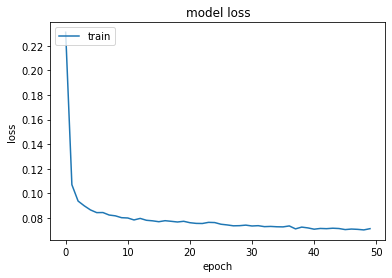

In [12]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [13]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window_size: ]
print ('len(test_data):', len(test_data))

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = LSTM_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


len(test_data): 17589
548/548 [==============================] - 4s 6ms/step


<ipython-input-14-315574608bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


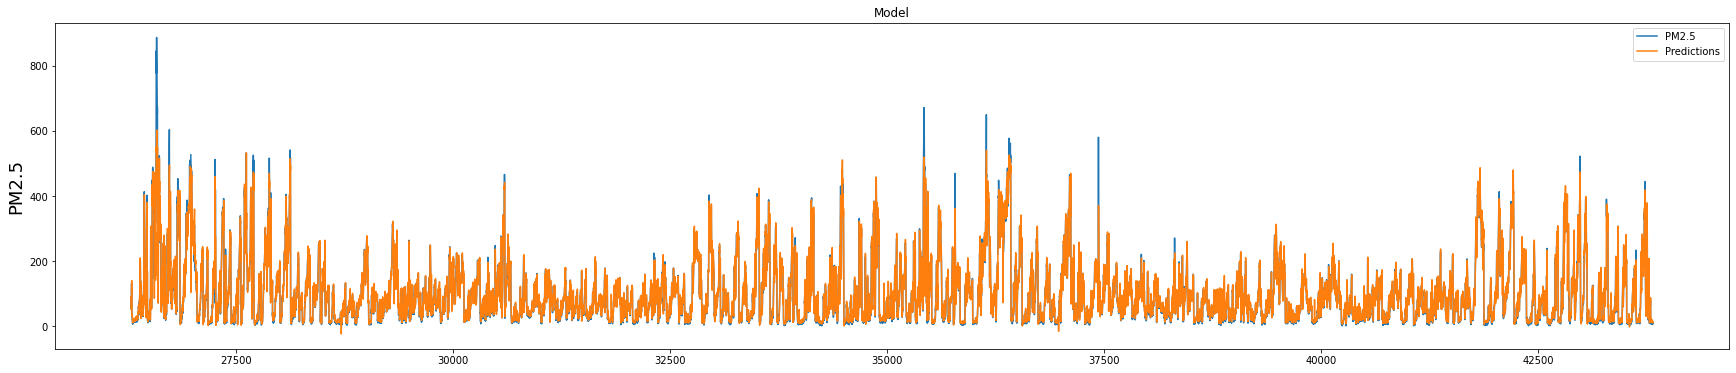

In [14]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(30,6))
plt.title('Model')
plt.ylabel('PM2.5', fontsize=18)
#plt.plot(train['Close'])
plt.plot(test[['pm2.5', 'Predictions']])
plt.legend(['PM2.5', 'Predictions'], loc='upper right')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(test['Predictions'],y_test)
mse = mean_squared_error(test['Predictions'], y_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Predictions'],y_test)
r = r2_score(test['Predictions'], y_test)

In [16]:
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)
print('R-Squared Score = {}'.format(r))

Mean Absolute Error: 13.168895328319682
Mean Squared Error: 624.293522955938
Root Mean Squared Error: 24.985866463981953
Mean Absolute Percentage Error: 0.18758860754923287
R-Squared Score = 0.9274694479081359
